In [1]:
import os,sys
import random
import numpy as np
import networkx as nx

sys.path.append(os.path.realpath('lib'))
from lib.data_loader import load_local_data

This notebook just gives an idea about the dataset, it's nature features. It will be further extended. 
I selected a dataset which is big enough to test learning-based methods and has non-discreet attributes for its nodes and edges.

## Dataset
Aids dataset is selected for the first test. It contains 2000 graphs with attributes for a binary classification task.

In [2]:
dataset_n='aids'
path='data/'
X,y=load_local_data(path,dataset_n, attributes=True, use_node_deg=False)

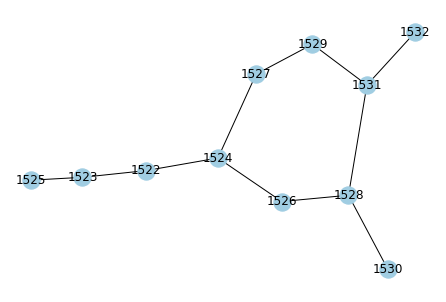

In [3]:
# now display a couple of random graphs from the dataset with different labels
random_class1 = random.choice(list(np.where(y == 1)[0])) 
random_class2 = random.choice(list(np.where(y == 0)[0]))
nx.draw(X[random_class1].nx_graph, node_color='#A0CDE2', with_labels = True)


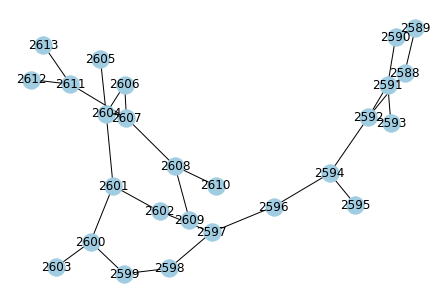

In [4]:
nx.draw(X[random_class2].nx_graph, node_color='#A0CDE2', with_labels = True)

## Display attributes of nodes

In [5]:
nx.get_node_attributes(X[random_class2].nx_graph, 'attr_name')
# maybe we need to normalize all the attributes? To decide    

{2588: [1.0, 0.0, 6.4346, -4.1433],
 2589: [1.0, 0.0, 7.4128, -4.3512],
 2592: [1.0, 0.0, 6.3301, -3.1488],
 2590: [2.0, 0.0, 7.9128, -3.4852],
 2591: [1.0, 0.0, 7.2437, -2.7421],
 2593: [1.0, 0.0, 7.4516, -1.7639],
 2594: [1.0, 0.0, 5.4641, -2.6488],
 2595: [5.0, 0.0, 4.5981, -3.1488],
 2596: [4.0, 0.0, 5.4641, -1.6488],
 2597: [1.0, 0.0, 4.5981, -1.1488],
 2598: [1.0, 0.0, 3.732, -1.6488],
 2602: [1.0, 0.0, 4.5981, -0.1488],
 2599: [1.0, 0.0, 2.866, -1.1488],
 2600: [1.0, 0.0, 2.866, -0.1488],
 2601: [1.0, 0.0, 3.7321, 0.3512],
 2603: [7.0, 0.0, 2.0, 0.3512],
 2604: [1.0, 0.0, 3.7321, 1.3512],
 2605: [2.0, 0.0, 2.866, 1.8512],
 2606: [2.0, 0.0, 4.5981, 1.8512],
 2607: [1.0, 0.0, 4.5981, 2.8512],
 2608: [1.0, 0.0, 5.4641, 3.3512],
 2611: [1.0, 0.0, 3.7321, 3.3512],
 2609: [1.0, 0.0, 5.4641, 4.3512],
 2610: [1.0, 0.0, 6.3301, 2.8512],
 2612: [1.0, 0.0, 3.7321, 4.3512],
 2613: [1.0, 0.0, 2.866, 2.8512]}

## Random Walk geneartion

Random walk definitions for graphs with attributes

In [6]:
def randomWalk(G, walkSize, restart=None):
    walkList = []
    curNode = random.choice(list(G.nodes))
    while (len(walkList) < walkSize):
        attributes = G._node[curNode]['attr_name']
        # find the corresponding key-label using kmeans centers
        walkList.append(attributes)
        # get a new node
        try:
            curNode = random.choice([*G.adj[curNode]._atlas.keys()])
        except: # this is the case when the node has no direct neighbors
            curNode = random.choice(list(G.nodes))
            # restart the node selection again -- this is useful for graphs with loose nodes possible
        if restart and len(walkList) % restart == 0:
            curNode = random.choice(list(G.nodes))

    return walkList

def generateWalks(graphs_list, walkLength):
    random_walks = []
    for graph in graphs_list:
        nx_graph = graph.nx_graph # get the graph
        walk = randomWalk(nx_graph, walkLength, 1000)
        random_walks.append(walk)

    return random_walks

In [14]:
# generate random walks for the AIDS dataset
features = generateWalks(X, 500)



In [15]:
# reshape so the features shape is N, W (walk size), A (attributes)
features = np.array(features)
features = features.reshape((len(X),500,4))

In [17]:
print(features.shape)

(2000, 500, 4)


In [19]:
print(features[0,0,:]) # single node example

[ 1.      0.     11.5088 -1.549 ]


## Transformer architecture
Will take features and labels (features, y) as an input, perform the random walk on graph nodes (storing the attributes on its way) and then put a transformer on top to produce a graph embedding.

In [1]:
# todo - work on transformer architectures and applications. 